In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import itertools
import importlib
import config
importlib.reload(config)
from config import BIN_SIZE as bin_size
from config import ANALYSIS_MODE as analysis_mode
from config import SPECIFIC_GROUP as specific_group
from config import STRATIFY_BY as stratify

# 1. Loading of Dataframes

In [2]:
print(analysis_mode)
print(specific_group)
print(bin_size)

matrix_path = f"/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/final_feature_matrix_gc_corrected_{bin_size}.tsv"
df = pd.read_csv(matrix_path, sep="\t")

clinical_path = "/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/filtered_clinical_characteristics.csv"
clinical_df_raw = pd.read_csv(clinical_path, sep=";")

if analysis_mode == "specific_vs_healthy":
    clinical_df = clinical_df_raw[
            (clinical_df_raw["Patient Type"] == specific_group) |
            (clinical_df_raw["Patient Type"].str.lower() == "healthy")
        ].copy()
else:
    clinical_df = clinical_df_raw.copy()

if stratify =="Gender":
    clinical_df = clinical_df[clinical_df["Gender"].isin(["M", "F"])]
else:
    clinical_df = clinical_df
# Balancing: Sample as many Healthy as there are Cancer samples
cancer_df = clinical_df[clinical_df["Patient Type"].str.lower() != "healthy"]
print(cancer_df.shape)
healthy_df = clinical_df[clinical_df["Patient Type"].str.lower() == "healthy"]
print(healthy_df.shape)
n_cancer = len(cancer_df)

healthy_df = healthy_df.sample(n=n_cancer, random_state=42)
clinical_df = pd.concat([cancer_df, healthy_df]).copy()
print(len(healthy_df))
print(len(cancer_df))

valid_samples = clinical_df["Extracted_ID"].unique()
df = df[df["sample"].isin(valid_samples)].copy()

print(f"Number of Samples in Matrix: {df['sample'].nunique()}")
print(f"Number of Bins per Sample: {len(df) / df['sample'].nunique()}")


all_vs_healthy
Pancreatic Cancer
50000
(115, 19)
(129, 19)
115
115
Number of Samples in Matrix: 230
Number of Bins per Sample: 4260.0


# 2. Pipeline for LASSO

In [3]:
C_values = np.logspace(-2, 2, 50)
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('lasso_cv', LogisticRegressionCV(
        Cs=C_values,
        penalty='l1',
        solver='liblinear',
        cv=5,
        scoring='roc_auc',
        max_iter=10000,
        random_state=42
    ))
])

# 3. General Function for LASSO perfomance

In [4]:
def run_lasso_for_metrics(df, clinical_df, metrics, pipeline):
    # Pivot
    pivot_df = df.pivot(
        index="sample",
        columns="bin_id",
        values=list(metrics)
    )
    pivot_df.columns = [
        f"{metric}_{bin_id}" for metric, bin_id in pivot_df.columns
    ]

    # Labels and Stratification
    y = []
    strata = []

    for sample_id in pivot_df.index:
        row = clinical_df[clinical_df["Extracted_ID"] == sample_id].iloc[0]
        
        is_healthy = row["Patient Type"].lower() == "healthy"
        target_val = 0 if is_healthy else 1
        y.append(target_val)
        
        if stratify == "Gender":
            strata.append(row["Gender"])
        else:
            strata.append(target_val)

    y = np.array(y)
    X = pivot_df

    print(f"Number Cancer: {sum(y)}")
    print(f"Number Healthy: {len(y) - sum(y)}")

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.3,
        stratify=strata,
        random_state=42
    )

    # Fit
    pipeline.fit(X_train, y_train)

    # Predict
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_prob)

    # Koeffizienten
    lasso_model = pipeline.named_steps['lasso_cv']
    n_selected = np.sum(lasso_model.coef_[0] != 0)

    return {
        "metrics": metrics,
        "n_metrics": len(metrics),
        "n_features": X.shape[1],
        "n_selected_features": int(n_selected),
        "roc_auc": auc_score,
        "best_C": lasso_model.C_[0]
    }


# 4. Feature Selektion for LASSO (combinations of metrics)

In [5]:
df["bin_id"] = df["chrom"] + "_" + df["start"].astype(str)

metrics = [
    "mean", 
    "median", 
    "stdev", 
    "wps_value",
    "min",
    "max",	
]

metrics_results =[]

for r in range (1, len(metrics) + 1):
    for combination in itertools.combinations(metrics, r):
        res = run_lasso_for_metrics(df, clinical_df, combination, pipeline)
        metrics_results.append(res)

# nehme wps auf jeden fall mit rein 
metrics_with_wps = []
for metric in metrics_results:
    if any("wps_value" in m for m in metric["metrics"]):
        metrics_with_wps.append(metric)
    else:
        #metrics_with_wps.append(metric) #mach ich nur um verschiedene kombis auch ohne wps zu testen 
        continue
print(pd.DataFrame(metrics_with_wps).columns)
print(metrics_with_wps[0].keys())

metrics_with_wps = pd.DataFrame(metrics_with_wps).sort_values("roc_auc", ascending=False)
metrics_with_wps.to_csv("/labmed/workspace/lotta/finaletoolkit/dataframes_notebooklasso_metrics_results.csv", index=False)

print("10 Best metric combinations:")
print(metrics_with_wps.head(10))

best_metrics = metrics_with_wps.iloc[0]['metrics']
print("Best metrics:", best_metrics)


Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115


Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number Healthy: 115
Number Cancer: 115
Number

# 5. Influence of metric selection on model performance

<AxesSubplot:title={'center':'Mean ROC AUC vs Number of Metrics'}, xlabel='Number of Metrics', ylabel='ROC AUC'>

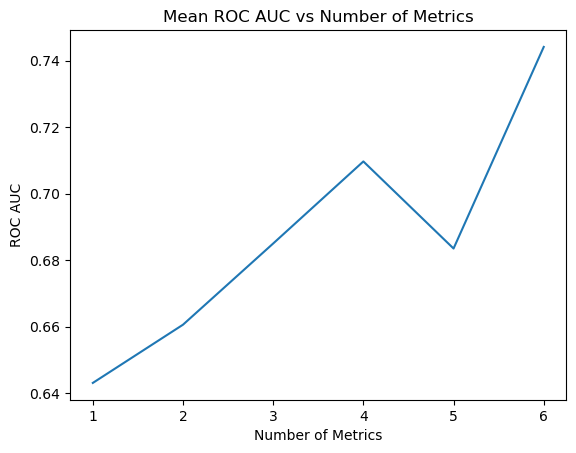

In [6]:
metrics_with_wps.groupby("n_metrics")["roc_auc"].mean().plot(
    title="Mean ROC AUC vs Number of Metrics",
    ylabel="ROC AUC",
    xlabel="Number of Metrics"
)

### 5.1 Lasso Modeling with best C parameter 

The `LogisticRegressionCV` model automatically tried out different values for the parameter `C`. 
Here we visualize how the accuracy of the model changes with `C`.

- **Small C**: Strong regularization (model is “forced” to find simple solutions). Risk of underfitting.
- **Large C**: Weak regularization (model can be more complex). Risk of overfitting.
- **Best C**: The value that achieved the best balance and thus the highest score in cross-validation (CV).

The Reciever operating characteristic curve plots the true positive (TP) rate versus the false positive (FP) rate at different classification thresholds. 

The thresholds are different probability cutoffs that separate the two classes in binary classification. It uses probability to tell us how well a model separates the classes.

Re-training model with best metrics: ('mean', 'median', 'wps_value', 'min')


Confirmed ROC AUC on test set: 0.7505


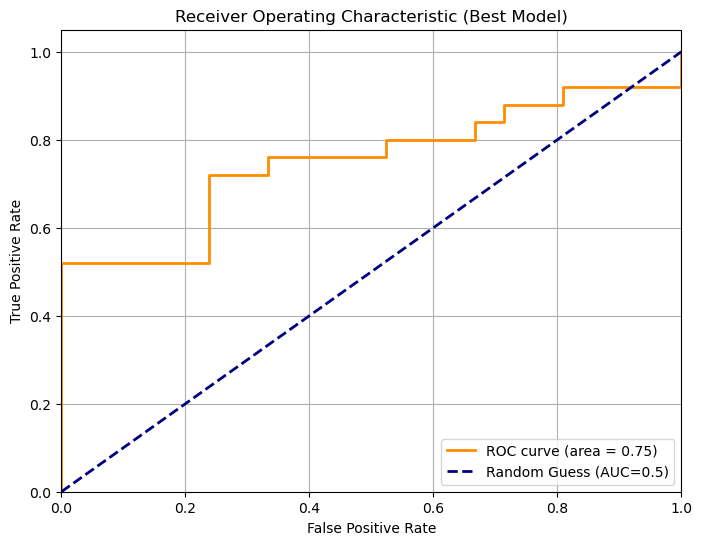

<Figure size 640x480 with 0 Axes>

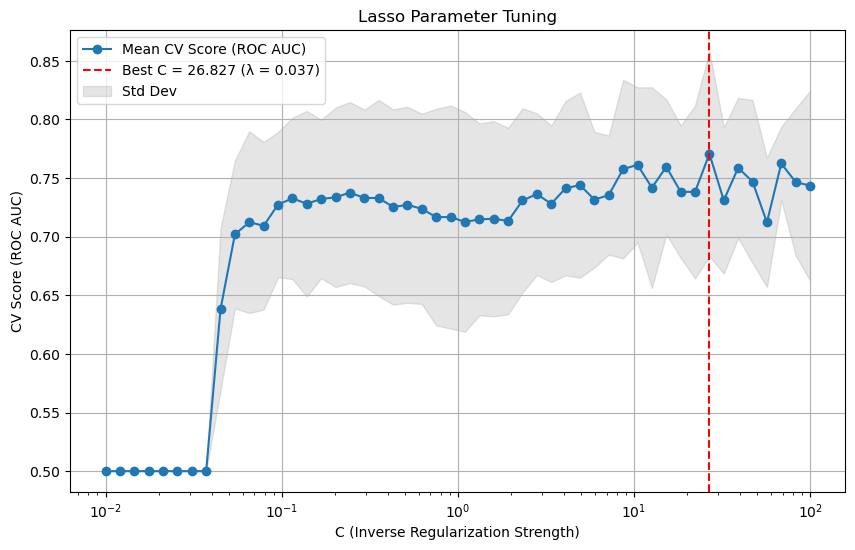

<Figure size 640x480 with 0 Axes>

In [7]:
print(f"Re-training model with best metrics: {best_metrics}")

# Pivot
pivot_df = df.pivot(
    index="sample",
    columns="bin_id",
    values=list(best_metrics)
)
pivot_df.columns = [
    f"{metric}_{bin_id}" for metric, bin_id in pivot_df.columns
]

# Labels
y = []
strata = []
for sample_id in pivot_df.index:
    row = clinical_df[clinical_df["Extracted_ID"] == sample_id].iloc[0]
    is_healthy = row["Patient Type"].lower() == "healthy"
    target_val = 0 if is_healthy else 1
    y.append(target_val)
    if stratify == "Gender":
        strata.append(row["Gender"])
    else:
        strata.append(target_val)

y = np.array(y)
X = pivot_df

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=strata,
    random_state=42,
)

# Fit
pipeline.fit(X_train, y_train)

# Predict
# berechen wahrscheinlichkeiten für krebs [:,1] da gebraucht für ROC
y_prob = pipeline.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print(f"Confirmed ROC AUC on test set: {auc_score:.4f}")

lasso_cv = pipeline.named_steps['lasso_cv']

# --- ROC Curve Plot ---
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--', label='Random Guess (AUC=0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Best Model)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/roc_curve_{bin_size}.png")

#print(f"lasso cv scores: {lasso_cv.scores_}")
mean_scores = np.mean(lasso_cv.scores_[1], axis=0)
#print(f"mean scores: {mean_scores}")    
std_scores = np.std(lasso_cv.scores_[1], axis=0)
#print(f"std scores: {std_scores}")
cs = lasso_cv.Cs_
best_idx = np.argmax(mean_scores)
best_c = float(cs[best_idx])

# vcglmnet lamda.1se ( größtes lamda dessen score 1 se vom optimum liegt)
best_idx = np.argmax(mean_scores)
best_score = mean_scores[best_idx]
best_se = std_scores[best_idx]
threshold = best_score - best_se
c_1se = cs[np.where(mean_scores >= threshold)[0][0]]
#print(f"c_1se: {c_1se}, lambda_1se: {1/c_1se}")

# --- Lasso Parameter Tuning Plot ---
plt.figure(figsize=(10,6))
plt.semilogx(cs, mean_scores, marker='o', label='Mean CV Score (ROC AUC)')
plt.fill_between(cs, mean_scores - std_scores, mean_scores + std_scores, alpha=0.2, color='gray', label='Std Dev')
plt.axvline(best_c, linestyle='--', color='r', label=f'Best C = {best_c:.3f} (λ = {1/best_c:.3f})')
plt.title("Lasso Parameter Tuning")
plt.xlabel("C (Inverse Regularization Strength)")
plt.ylabel("CV Score (ROC AUC)")
plt.legend()
plt.grid(True)
plt.show()
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/lasso_parameter_tuning{bin_size}.png")


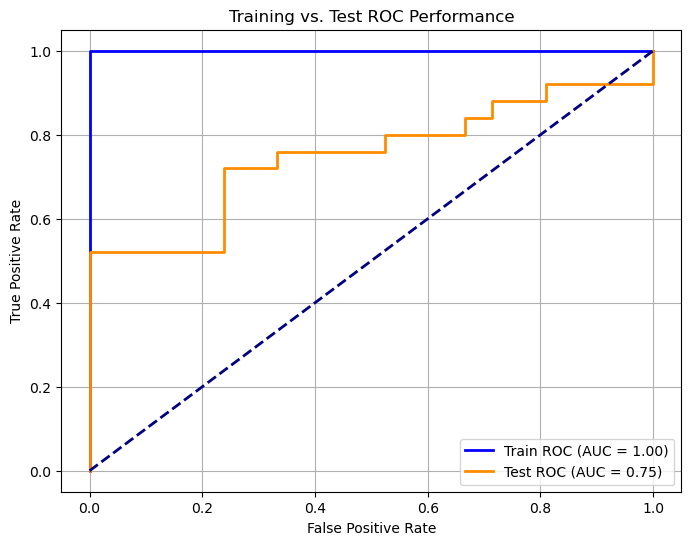

In [8]:
y_prob_train = pipeline.predict_proba(X_train)[:, 1]
y_prob_test = pipeline.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)

plt.figure(figsize=(8, 6))
auc_train = roc_auc_score(y_train, y_prob_train)
auc_test = roc_auc_score(y_test, y_prob_test)
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC (AUC = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test ROC (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.title('Training vs. Test ROC Performance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 5.2 Lasso Modeling with c_1se parameter 

Confirmed ROC AUC (1se Model) on test set: 0.6457


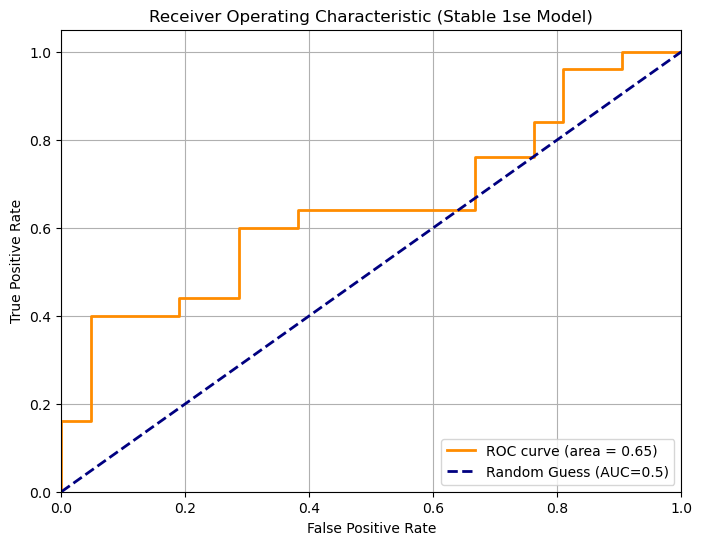

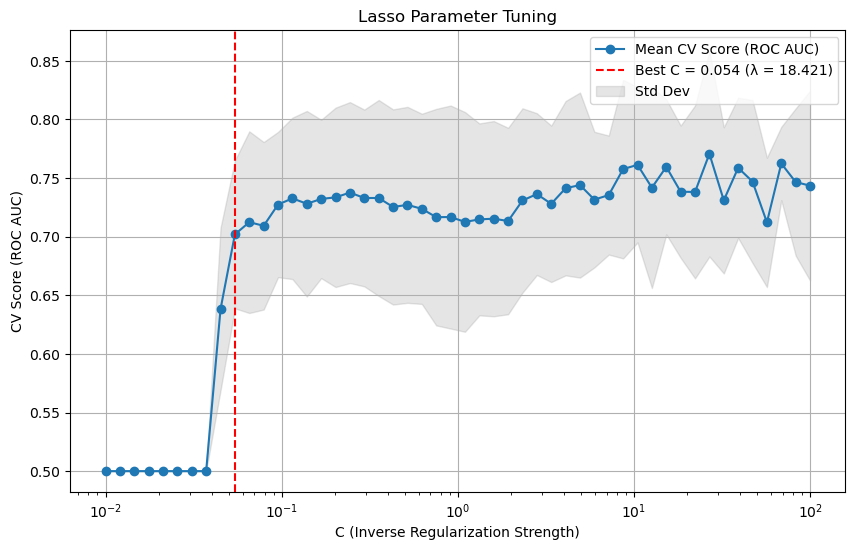

Anzahl selektierter Features im stabilen Modell: 16


In [9]:
# --- STABILERES MODELL MIT C_1SE ---

stable_lasso = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=c_1se,
    max_iter=10000,
    random_state=42
)

stable_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', stable_lasso)
])

stable_pipeline.fit(X_train, y_train)

y_prob = stable_pipeline.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print(f"Confirmed ROC AUC (1se Model) on test set: {auc_score:.4f}")

# --- ROC Curve Plot ---
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--', label='Random Guess (AUC=0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Stable 1se Model)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.semilogx(cs, mean_scores, marker='o', label='Mean CV Score (ROC AUC)')
plt.fill_between(cs, mean_scores - std_scores, mean_scores + std_scores, alpha=0.2, color='gray', label='Std Dev')
plt.axvline(c_1se, linestyle='--', color='r', label=f'Best C = {c_1se:.3f} (λ = {1/c_1se:.3f})')
plt.title("Lasso Parameter Tuning")
plt.xlabel("C (Inverse Regularization Strength)")
plt.ylabel("CV Score (ROC AUC)")
plt.legend()
plt.grid(True)
plt.show()

# --- Feature Analyse für das stabile Modell ---

coef_stable = stable_pipeline.named_steps['model'].coef_[0]
n_features_stable = np.sum(coef_stable != 0)
print(f"Anzahl selektierter Features im stabilen Modell: {n_features_stable}")

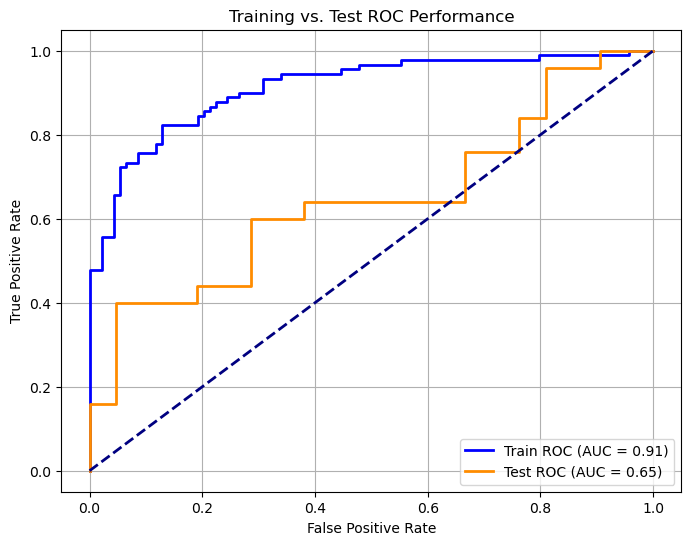

In [10]:
y_prob_train = stable_pipeline.predict_proba(X_train)[:, 1]
y_prob_test = stable_pipeline.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)

auc_train = roc_auc_score(y_train, y_prob_train)
auc_test = roc_auc_score(y_test, y_prob_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC (AUC = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test ROC (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.title('Training vs. Test ROC Performance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 6. Selected Important Features


In [11]:
from cv_lasso_single_fold import cross_validation, analyze_feature_stability, plot_roc_curves, plot_auc_boxplot

# --- A. Single Model Analysis (Current Split) ---
# ich nehme hier das cv model, also das ohne den festen c wert
lasso_model = pipeline.named_steps['lasso_cv']

coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lasso_model.coef_[0]
})
# Filtere Features, die NICHT 0 sind
important_features = coef_df[coef_df["Coefficient"] != 0].sort_values(by="Coefficient", ascending=False)

print(f"Number of Important Features (Single Model): {len(important_features)}")
print("\nTop Features (Single Model - Positive = Indikative for Cancer):")
print(important_features.head(20))

Number of Important Features (Single Model): 560

Top Features (Single Model - Positive = Indikative for Cancer):
                        Feature  Coefficient
10239  wps_value_chr19_42400000     0.580346
12580    wps_value_chr8_8950000     0.364886
10057   wps_value_chr18_3200000     0.331454
8947   wps_value_chr11_76200000     0.265293
13503        min_chr13_20750000     0.251603
14475        min_chr19_38200000     0.248025
11556   wps_value_chr3_45900000     0.238245
11348   wps_value_chr2_68800000     0.235722
12650  wps_value_chr9_130400000     0.234695
10071   wps_value_chr18_3850000     0.216003
11686   wps_value_chr4_16200000     0.214650
11987   wps_value_chr5_96800000     0.211493
11868  wps_value_chr5_151300000     0.202684
9343   wps_value_chr14_23950000     0.188761
12460   wps_value_chr8_11400000     0.178948
14991         min_chr1_45650000     0.176089
9089   wps_value_chr12_22050000     0.172280
14189        min_chr17_51200000     0.170995
11870  wps_value_chr5_151550000

# 7. Feature Stability Analysis (Cross-Validation) 


In [12]:
print(bin_size)

50000


Running 5-Fold Cross-Validation for Feature Stability.
Fold 1/5...


  AUC = 0.690, Best C = 56.89866029018293
Fold 2/5...
  AUC = 0.786, Best C = 82.86427728546842
Fold 3/5...
  AUC = 0.781, Best C = 100.0
Fold 4/5...
  AUC = 0.779, Best C = 47.1486636345739
Fold 5/5...
  AUC = 0.743, Best C = 68.66488450042998


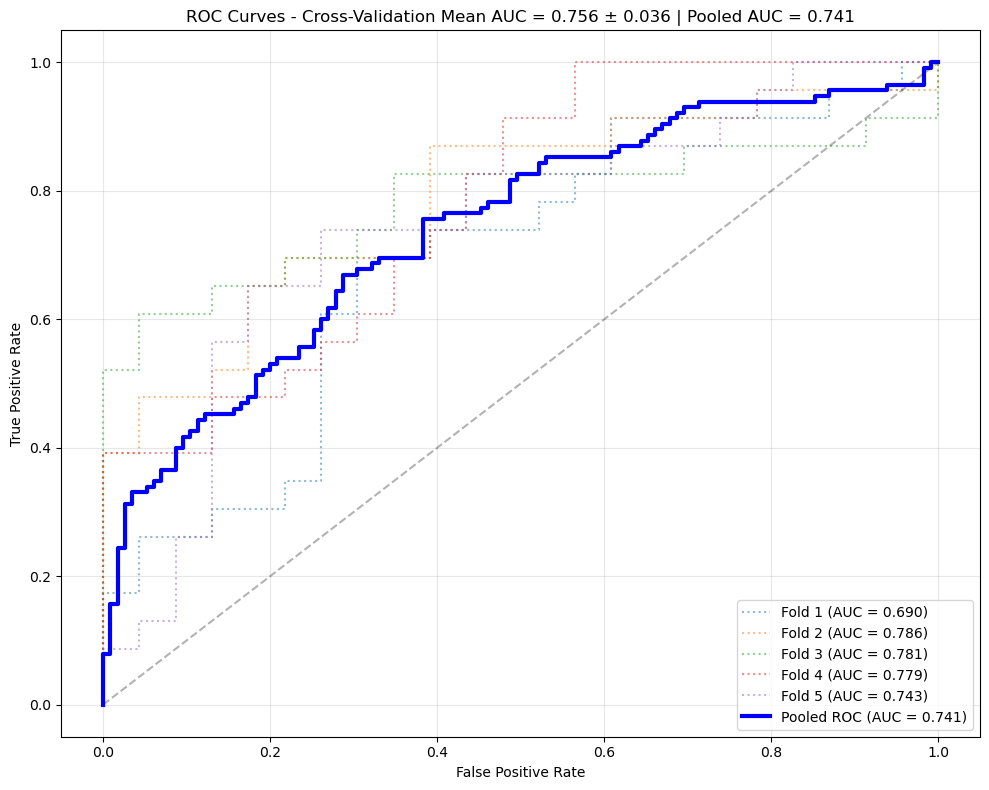

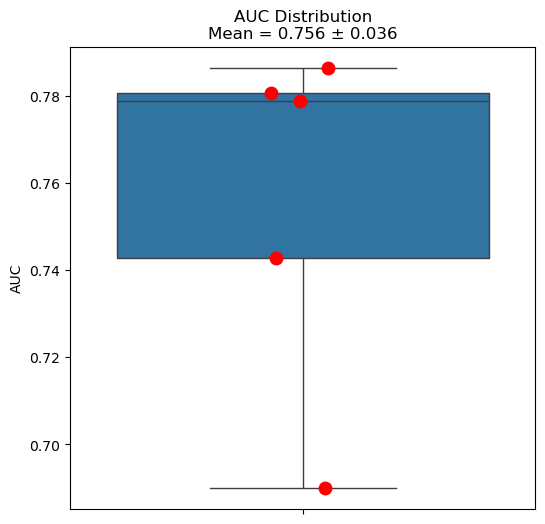

Number of Stable Features (Selected across multiple folds): 99

Top Stable Features (Selected across multiple folds):
                      Feature  Frequency  Frequency_Percent  Mean_Coef
227  wps_value_chr12_22050000          5              100.0   0.280128
378  wps_value_chr19_42400000          5              100.0   0.246769
590  wps_value_chr5_151300000          5              100.0   0.218340
766         min_chr1_45650000          5              100.0   0.204496
746        min_chr17_51200000          5              100.0   0.201673
689    wps_value_chr8_8950000          5              100.0   0.160068
373  wps_value_chr19_32400000          5              100.0   0.145778
421   wps_value_chr1_22150000          5              100.0   0.142401
670   wps_value_chr8_11600000          5              100.0   0.141144
243  wps_value_chr12_93550000          5              100.0   0.138885
232  wps_value_chr12_48000000          5              100.0   0.137618
346  wps_value_chr17_75200000 

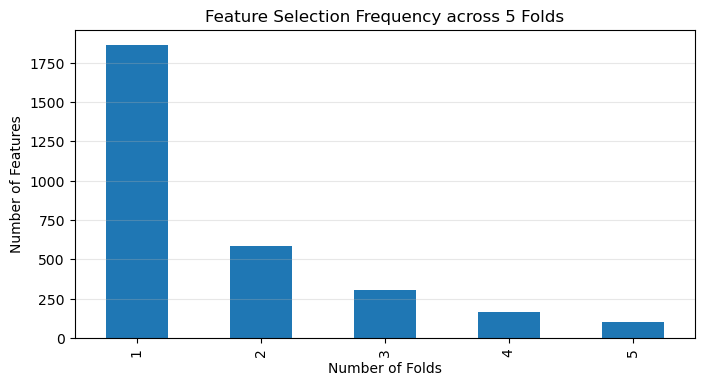

99


In [13]:
import importlib
import cv_lasso_single_fold
importlib.reload(cv_lasso_single_fold)
from cv_lasso_single_fold import plot_roc_curves
print("Running 5-Fold Cross-Validation for Feature Stability.")

# X and y should be available from previous cells. 
# We use X (full pivot_df before split if available, or regenerate if needed).
# Assuming X and y are the full datasets as defined before train_test_split.

# Re-verify label consistency
cv_results = cross_validation(X, y, pipeline, n_folds=5)

# Plotte Performance
plot_roc_curves(cv_results)
plot_auc_boxplot(cv_results)

# Feature Stability Analyse
stability_df = analyze_feature_stability(cv_results)
n_folds = 5
stable_in_all = stability_df[stability_df['Frequency'] == n_folds]
anzahl_stable = len(stable_in_all)
print("Number of Stable Features (Selected across multiple folds):", anzahl_stable)
print("\nTop Stable Features (Selected across multiple folds):")
print(stability_df.head(20))

# Histogram
plt.figure(figsize=(8, 4))
stability_df['Frequency'].value_counts().sort_index().plot(kind='bar')
plt.title('Feature Selection Frequency across 5 Folds')
plt.xlabel('Number of Folds')
plt.ylabel('Number of Features')
plt.grid(axis='y', alpha=0.3)
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/roc_curve_{bin_size}_fold.png")
plt.show()
print(len(stable_in_all))

# 8. Visualize the ROC Calculation (Label, Probability)

In [14]:
# 1. Wahrscheinlichkeiten für das Test-Set holen
y_prob_test = pipeline.predict_proba(X_test)[:, 1]

# 2. DataFrame erstellen, um die Vorhersagen den Proben-IDs zuzuordnen
test_results = pd.DataFrame({
    'Sample_ID': X_test.index,
    'True_Label': y_test,
    'Probability_Cancer': y_prob_test
})

# 3. Nach Wahrscheinlichkeit sortieren (so "wandert" die ROC-Kurve)
test_results = test_results.sort_values(by='Probability_Cancer', ascending=False).reset_index(drop=True)

# 4. Anzeige der Tabelle
print("Detailed predicitions for test set:")
print(test_results)

# Optional: Speichern als CSV, um es in Excel genauer anzusehen
# test_results.to_csv("test_set_predictions_analysis.csv", index=False)


Detailed predicitions for test set:
   Sample_ID  True_Label  Probability_Cancer
0    EE88294           1            0.999999
1    EE88325           1            0.999827
2    EE88295           1            0.995400
3    EE88323           1            0.978891
4    EE87865           1            0.952973
5    EE87806           1            0.947705
6    EE87873           1            0.945289
7    EE88303           1            0.942400
8    EE88298           1            0.932402
9    EE87896           1            0.924779
10   EE87876           1            0.901080
11   EE88312           1            0.875792
12   EE87883           1            0.851928
13   EE87962           0            0.851488
14   EE88020           0            0.798351
15   EE88014           0            0.796823
16   EE85970           0            0.794799
17   EE87956           0            0.785743
18   EE87913           1            0.751240
19   EE87809           1            0.721452
20   EE87807       

In [15]:
# Falsch-Negative (Krebs als gesund vorhergesagt)
fn_proben = test_results[(test_results['True_Label'] == 1) & (test_results['Probability_Cancer'] < 0.3)]

# Falsch-Positive (Gesund als Krebs vorhergesagt)
fp_proben = test_results[(test_results['True_Label'] == 0) & (test_results['Probability_Cancer'] > 0.7)]

# Merge outliers with test_results to get the probabilities
outliers_meta = pd.concat([fn_proben, fp_proben])
if not outliers_meta.empty:
    ausreisser_klinik = clinical_df.merge(outliers_meta[['Sample_ID', 'Probability_Cancer', 'True_Label']], 
                                         left_on='Extracted_ID', right_on='Sample_ID')
    print(f"Found outliers with threshold (FN < 0.3, FP > 0.7): {len(ausreisser_klinik)}")
    print(ausreisser_klinik[['Extracted_ID', 'Patient Type', 'Gender', 'Probability_Cancer']])
else:
    print("No outliers found.")


Found outliers with threshold (FN < 0.3, FP > 0.7): 11
   Extracted_ID       Patient Type Gender  Probability_Cancer
0       EE87794   Bile Duct Cancer      F            0.041085
1       EE87897     Gastric cancer      F            0.267866
2       EE87902     Gastric cancer      M            0.002146
3       EE87906     Gastric cancer      M            0.062937
4       EE87914     Gastric cancer      M            0.090224
5       EE86270  Pancreatic Cancer      M            0.000077
6       EE88020            Healthy      F            0.798351
7       EE88014            Healthy      M            0.796823
8       EE85970            Healthy      M            0.794799
9       EE87962            Healthy      M            0.851488
10      EE87956            Healthy      F            0.785743
